<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [1]:
import taiko as tk
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import math
from datetime import datetime, timedelta
from collections import deque
from scipy.stats import mode
from tqdm import tqdm
import lightgbm as lgb
from sklearn import metrics
from abc import abstractmethod
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
sns.set()

pd.options.display.float_format = '{:,.4f}'.format

# preprocessing.primitive
RMS_COLS = ['a_rms', 'g_rms', 'imu_ax', 'imu_ay', 'imu_az', 'imu_gx', 'imu_gy', 'imu_gz']
WHO = 9
SONG = 1
ORDER = 2

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('CSV/profile/myprof.csv')
train_df

,hit_type,L_A_AI,L_G_AI,L_AX_AI,L_AY_AI,L_AZ_AI,L_GX_AI,L_GY_AI,L_GZ_AI,L_A_VI,...,R_GYZ_CORR,R_GZX_CORR,LR_A_DTW,LR_G_DTW,LR_AX_DTW,LR_AY_DTW,LR_AZ_DTW,LR_GX_DTW,LR_GY_DTW,LR_GZ_DTW
0,1,0.4501,9.9030,0.0350,0.1229,0.0088,-2.9990,2.6390,3.7770,0.0375,...,0.5596,-0.8174,113.6000,"2,037.0000",45.3900,94.7900,64.1100,"1,220.0000",773.6000,"1,619.0000"
1,1,0.6183,7.6510,0.2940,0.3672,-0.1511,1.2980,0.7243,-0.1043,0.0674,...,0.5618,-0.8009,127.3000,"3,864.0000",48.6600,111.8000,43.0700,"2,282.0000","1,086.0000","3,048.0000"
2,1,0.6753,14.0000,-0.1453,-0.1696,0.1898,1.0900,3.8540,6.8590,0.0720,...,0.3792,-0.8249,88.8200,"2,830.0000",44.5400,79.8500,60.3400,"1,807.0000",737.3000,"2,715.0000"
3,1,0.4137,7.2440,-0.2051,-0.1243,0.0127,1.4380,-1.3350,-1.8000,0.0599,...,0.6582,-0.8012,132.1000,"3,394.0000",43.9300,121.1000,53.8900,"1,794.0000",810.0000,"3,014.0000"
4,1,0.3583,6.4760,-0.0400,0.0295,-0.0799,-0.8075,2.7630,-1.0130,0.0415,...,0.6775,-0.8247,128.7000,"3,471.0000",42.2600,117.7000,45.3900,"1,760.0000",656.4000,"2,898.0000"
5,1,0.7175,8.7970,0.3411,0.4494,-0.2015,1.1120,0.0851,-1.1490,0.1194,...,0.6939,-0.7810,127.7000,"3,317.0000",44.9700,114.3000,47.3100,"1,735.0000",901.7000,"2,802.0000"
6,1,0.7370,6.7490,0.3916,0.4698,-0.1691,1.3100,1.2570,0.4036,0.0740,...,0.8197,-0.9033,139.5000,"3,841.0000",48.0400,127.1000,49.7400,"2,450.0000",680.6000,"3,231.0000"
7,1,0.7024,5.3930,0.4179,0.4790,-0.1437,0.5663,1.5810,0.8363,0.0368,...,0.7437,-0.7611,117.7000,"3,227.0000",46.1800,107.6000,44.8600,"1,641.0000",827.4000,"2,602.0000"
8,1,0.7193,6.4690,0.4139,0.4910,-0.1452,1.5180,0.9354,0.8580,0.0427,...,0.7655,-0.8572,130.3000,"3,863.0000",48.1700,117.7000,52.5200,"1,973.0000",830.2000,"3,296.0000"
9,1,0.7972,10.9700,0.4902,0.4929,-0.0929,-0.2027,2.8200,-1.8630,0.0875,...,0.5319,-0.8233,119.4000,"3,341.0000",43.9200,123.9000,44.3500,"1,693.0000",812.1000,"3,137.0000"


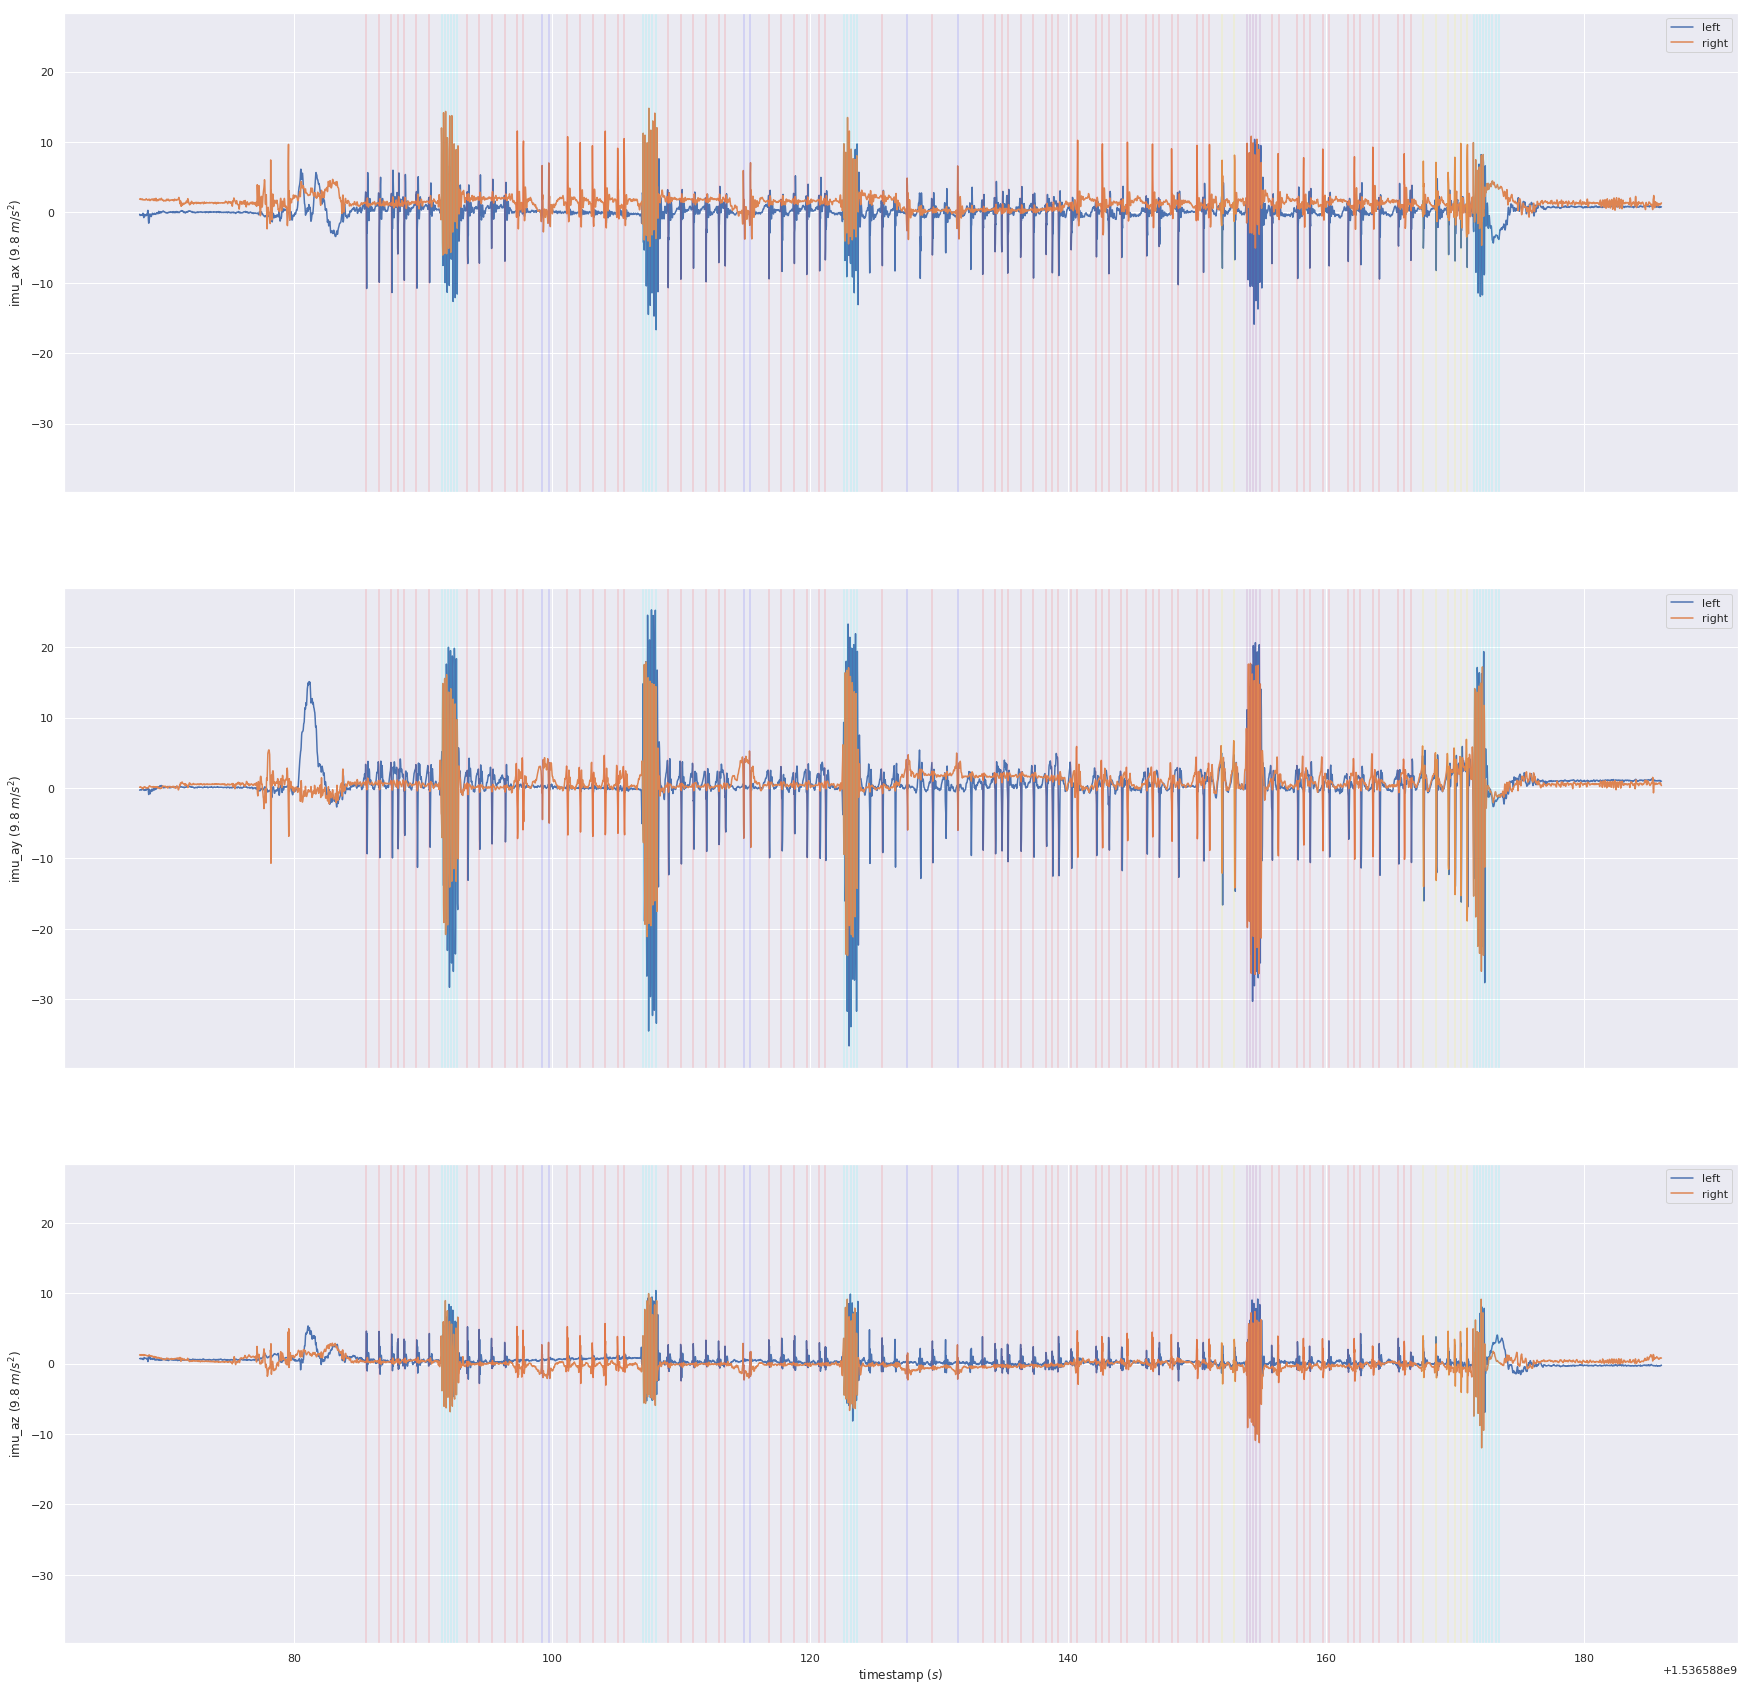

In [3]:
play = tk.get_play(WHO, SONG, ORDER)


show_cols = tk.ZERO_ADJ_COL[:3]
fig, axes = plt.subplots(nrows=len(show_cols), ncols=1, sharex=True, sharey=True, figsize=(30, 30))
for i_, col in enumerate(show_cols):
    sns.lineplot(data=play.play_dict['L'], x='timestamp', y=col, label='left', ax=axes[i_])
    sns.lineplot(data=play.play_dict['R'], x='timestamp', y=col, label='right', ax=axes[i_])
    axes[i_].set_ylabel(col + ' $(9.8\ m/s^2)$')
    events = play.events
    for id_, _ in enumerate(events):
        event_time = events[id_][0]
        hit_type = events[id_][1]
        if hit_type > 0:
            axes[i_].axvline(event_time, color=tk.COLORS[hit_type], alpha=1, lw=0.2)
plt.xlabel('timestamp $(s)$')
plt.show()

In [4]:
def create_ep(left_arm_df, right_arm_df, start_time, end_time, hit_type):
    tmp_primitive_mat = []
    
    windows = [deque() for _ in range(2)]
    left_window_df = left_arm_df[(left_arm_df.timestamp >= start_time) & (left_arm_df.timestamp <= end_time)]
    right_window_df = right_arm_df[(right_arm_df.timestamp >= start_time) & (right_arm_df.timestamp <= end_time)]

    for id_, row in left_window_df.iterrows():
        windows[0].append(row)
    
    for id_, row in right_window_df.iterrows():
        windows[1].append(row)

    feature_row = tk.get_features(windows)
    tmp_primitive_mat.append([hit_type] + feature_row)
    columns = tk.get_feature_columns(['L', 'R'])
    event_primitive_df = pd.DataFrame(data=tmp_primitive_mat,
                                      columns=['hit_type'] + columns)
    return event_primitive_df

In [5]:
def transform_hit_type_label_dong_ka(label):
    """
    Relabel the column.

    :param label: original label
    :return: transformed label
    """

    if label in [1, 3]:
        return 1
    elif label in [2, 4]:
        return 2
    elif label in [5, 6, 7]:
        return 3
    return 0

In [6]:
song_start_time = 1536587943.93
bmp_inv = 0.2439

ep_dfs = []
events = play.events
for id_, _ in tqdm(enumerate(events), total=len(events)):
    event_time = events[id_][0]
    hit_type = events[id_][1]
    now_time = event_time
    start_time = now_time - bmp_inv / 2.0
    end_time = now_time + bmp_inv / 2.0
    ep_df = create_ep(play.play_dict['L'], play.play_dict['R'], start_time, end_time, hit_type)
    ep_dfs.append(ep_df)

this_ep_df = pd.concat(ep_dfs, ignore_index=True)
this_ep_df.loc[:, 'hit_type'] = this_ep_df['hit_type'].apply(transform_hit_type_label_dong_ka)

100%|██████████| 362/362 [00:59<00:00,  6.04it/s]


In [7]:
test_df = this_ep_df

In [8]:
def my_f1_score(y_pred, y):
    y = y.get_label()
    y_pred = y_pred.reshape(len(np.unique(y)), -1).argmax(axis=0)
    return "f1-score", metrics.f1_score(y, y_pred, average="weighted"), True

In [9]:
x = train_df.drop(['hit_type'], axis=1)
y = train_df['hit_type']
train_set = lgb.Dataset(x, y)
valid_set = lgb.Dataset(x, y, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'learning_rate': 0.1,
    'application': 'multiclass',
    'max_depth': 4,
    'num_leaves': 2 ** 4,
    'verbosity': 0
})
my_params = params
my_params['num_classes'] = len(y.unique())
if params is not None:
    my_params.update(params)

model = lgb.train(my_params,
                  train_set=train_set,
                  valid_sets=watchlist,
                  num_boost_round=200,
                  verbose_eval=5,
                  early_stopping_rounds=100,
                  feval=my_f1_score)

x_test = test_df.drop(['hit_type'], axis=1)
y_true = test_df['hit_type']
y_pred = model.predict(x_test, num_iteration=model.best_iteration)
y_test = pd.Series(data=[np.argmax(xx) for xx in y_pred])

f1_score = round(metrics.f1_score(y_true, y_test, average='weighted'), 4)

print(classification_report(y_true, y_test))

/usr/bin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/bin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/bin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/bin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/bin/anaconda3/lib/python3.6/site-packag

Training until validation scores don't improve for 100 rounds.
[5]	valid_0's f1-score: 0.724664
[10]	valid_0's f1-score: 0.787687
[15]	valid_0's f1-score: 0.915938
[20]	valid_0's f1-score: 0.915938
[25]	valid_0's f1-score: 0.937183
[30]	valid_0's f1-score: 0.975437
[35]	valid_0's f1-score: 1
[40]	valid_0's f1-score: 1
[45]	valid_0's f1-score: 1
[50]	valid_0's f1-score: 1
[55]	valid_0's f1-score: 1
[60]	valid_0's f1-score: 1
[65]	valid_0's f1-score: 1
[70]	valid_0's f1-score: 1
[75]	valid_0's f1-score: 1
[80]	valid_0's f1-score: 1
[85]	valid_0's f1-score: 1
[90]	valid_0's f1-score: 1
[95]	valid_0's f1-score: 1
[100]	valid_0's f1-score: 1
[105]	valid_0's f1-score: 1
[110]	valid_0's f1-score: 1
[115]	valid_0's f1-score: 1
[120]	valid_0's f1-score: 1
[125]	valid_0's f1-score: 1
[130]	valid_0's f1-score: 1
[135]	valid_0's f1-score: 1
Early stopping, best iteration is:
[35]	valid_0's f1-score: 1
             precision    recall  f1-score   support

          0       0.92      0.14      0.24 

/usr/bin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/bin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
